## Importing Necessary Libraries

In [110]:
# These libraries will be used for EDA and data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

# These libraries will be used for machine learning models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Importing csv with engineered features and merging them 

In [111]:
pd.set_option('display.max_columns', 100) # shows all the columns

# loading all the datasets
features_1 = pd.read_csv('/Users/suborna/Github/Capstone_Project/Data/Final_Provider1.csv') # Anthony
features_2 = pd.read_csv('/Users/suborna/Github/Capstone_Project/Data/Final_Provider2.csv') # Suborna

# merging features_1 & features_2 to have the complete dataset of new features
All_Features = features_1.merge(features_2, on = 'Provider')

# setting provider as index for ML modeling
Train_set = features_1.merge(features_2, on = 'Provider').set_index('Provider')

# replacing categories with ordinal data for the Potential Fraud labels
Train_set['PotentialFraud'] = Train_set['PotentialFraud'].replace(['Yes', 'No'], [1,0])

# seperating the dataset into 2 frames: fraud & not fraud
## Potential Fraud dataset
fraud_df = All_Features.loc[All_Features.PotentialFraud == 'Yes']
Fraud_df = fraud_df.reset_index().rename(columns = {'index': 'Index'})

## Not Potential Fraud Dataset
nfraud_df = All_Features.loc[All_Features.PotentialFraud == 'No']
NFraud_df = nfraud_df.reset_index().rename(columns = {'index': 'Index'})

In [112]:
Train_set.isnull().sum().sum()

0

In [113]:
All_Features.shape # checking the count of rows and columns

(5410, 60)

In [114]:
# check the distribution of the potential fraud/Nfraud labels (0 means not potential fraud, 1 means potential fraud)
np.round(Train_set.PotentialFraud.value_counts()/All_Features.shape[0], 2)

0    0.91
1    0.09
Name: PotentialFraud, dtype: float64

In [115]:
All_Features.sample(5) # randomly sampling 5 rows of data

,Provider,CDC_4019,CDC_25000,CDC_2724,CDC_V5869,CDC_42731,CDC_4011,CDC_V5861,CDC_2449,CDC_2720,CDC_4280,DGC_882,DGC_884,DGC_166,DGC_183,DGC_939,DGC_883,DGC_168,DGC_887,DGC_204,DGC_867,CPC_4019.0,CPC_2724.0,CPC_9904.0,CPC_8154.0,CPC_66.0,CPC_3893.0,CPC_3995.0,CPC_4516.0,CPC_3722.0,CPC_8151.0,Male_Patient,Female_Patient,Age(26-40),Age(41-60),Age(61-80),Age(81-100),Race_White,Race_Black,Race_Hispanic,Race_Native,Hos_Stay_Total,Payment_Total,Claim_Len_Total,Alzheimer,Heartfailure,KidneyDisease,Cancer,ObstrPulmonary,Depression,Diabetes,IschemicHeart,Osteoporasis,rheumatoidarthritis,stroke,RenalDisease,State_Count,County_Count,DiagGroupCode,PotentialFraud
862,PRV52075,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,3.0,0.0,2.0,2.0,1.0,2.0,1.0,0.0,2.0,0.0,1220.0,20,1,2,1,1,1,1,2,5,1,1,0,0,1,1,0.0,No
386,PRV51487,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,11.0,0.0,1.0,8.0,3.0,6.0,2.0,4.0,0.0,0.0,9300.0,0,8,8,7,2,4,4,12,10,5,4,1,3,1,6,0.0,No
1466,PRV52820,5,3,0,1,2,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.0,18.0,0.0,1.0,22.0,7.0,25.0,3.0,1.0,1.0,0.0,6730.0,4,17,20,14,5,11,19,23,23,13,15,1,4,3,6,0.0,No
1298,PRV52614,18,6,9,11,3,11,4,5,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.0,64.0,2.0,4.0,58.0,30.0,82.0,9.0,0.0,3.0,0.0,42640.0,230,75,93,75,11,42,88,101,113,53,58,16,32,2,13,0.0,No
1385,PRV52721,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,3.0,0.0,1.0,4.0,2.0,5.0,0.0,2.0,0.0,0.0,1810.0,44,2,5,3,0,3,4,5,6,2,3,1,0,2,4,0.0,No


# Baseline model (Logistic Regression, No Penalty)

In [144]:
# Create instance of Logistic Regression Class
lm = LogisticRegression(class_weight = 'balanced', solver = 'saga', random_state = 42, max_iter = 10000)

In [145]:
# preparing dataset for train, test, split
X = Train_set.drop('PotentialFraud', axis = 1)
y = Train_set['PotentialFraud']

# spliting the dataset into training set & testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

# Grid Search 
params = {'C' : [0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3]}
gs_lr = GridSearchCV(lm, params, cv = 3, scoring = 'accuracy')

%time gs_lr.fit(X_train, y_train)

CPU times: user 1min 17s, sys: 535 ms, total: 1min 17s
Wall time: 1min 18s


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [146]:
print('Best Params:', gs_lr.best_params_)
print('Best Score:', gs_lr.best_score_)

Best Params: {'C': 0.12}
Best Score: 0.90256221717801


In [147]:
# Using Grid Search Hyperparameters for Featue Selection with Lasso Penalty
lm.set_params(class_weight = 'balanced', solver = 'saga', random_state = 42, C = 0.12)
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

In [148]:
lm.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=0.12, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=42, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)>

In [149]:
print('Train Set Score')
print(lm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(lm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))

Train Set Score
0.9078426194877212
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9008009858287123
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1343  121]
 [  40  119]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1464
           1       0.50      0.75      0.60       159

    accuracy                           0.90      1623
   macro avg       0.73      0.83      0.77      1623
weighted avg       0.92      0.90      0.91      1623



In [204]:
Feature_Importance1 = pd.DataFrame(np.column_stack(lm.coef_ ), index = X.columns, columns = ['Coefficients']).sort_values(ascending = False, by = 'Coefficients').reset_index()
Feature_Importance1.loc[Feature_Importance1.Coefficients > 0.0099]

,index,Coefficients
0,Payment_Total,1.523955
1,Hos_Stay_Total,1.174641
2,RenalDisease,0.331702
3,CDC_42731,0.283980
4,stroke,0.248491
5,CPC_66.0,0.182121
6,DGC_183,0.130161
7,DGC_867,0.077975
8,DGC_204,0.028054


# Logistic Regression (Lasso Penalty for Feature Selection)

In [151]:
X = Train_set.drop('PotentialFraud', axis = 1)
y = Train_set['PotentialFraud']

# spliting the dataset into training set & testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

In [152]:
# Grid Search 
params = {'C' : [0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3], 'penalty': ['l1']}
gs_lr = GridSearchCV(lm, params, cv = 3, scoring = 'accuracy')

%time gs_lr.fit(X_train, y_train)

CPU times: user 2min 14s, sys: 895 ms, total: 2min 15s
Wall time: 2min 16s


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=0.12, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3],
                         'penalty': ['l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [153]:
print('Best Params:', gs_lr.best_params_)
print('Best Score:', gs_lr.best_score_)

Best Params: {'C': 0.1, 'penalty': 'l1'}
Best Score: 0.9025613806585833


In [154]:
# Using Grid Search Hyperparameters for Featue Selection with Lasso Penalty
lm.set_params(class_weight = 'balanced', solver = 'saga', random_state = 42, C = 0.1, penalty = 'l1')
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

In [155]:
lm.get_params # checking the parameters 

<bound method BaseEstimator.get_params of LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=42, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)>

In [156]:
print('Train Set Score')
print(lm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(lm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.9067863744388698
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9063462723351817
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1348  116]
 [  36  123]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1464
           1       0.51      0.77      0.62       159

    accuracy                           0.91      1623
   macro avg       0.74      0.85      0.78      1623
weighted avg       0.93      0.91      0.91      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


In [205]:
Feature_Importance2 = pd.DataFrame(np.column_stack(lm.coef_ ), index = X.columns, columns = ['Coefficients']).\
sort_values(ascending = False, by = 'Coefficients').reset_index().rename(columns = {'index' : 'Features'})
Feature_Importance2.loc[Feature_Importance2.Coefficients > 0.0099]

,Features,Coefficients
0,Payment_Total,1.523955
1,Hos_Stay_Total,1.174641
2,RenalDisease,0.331702
3,CDC_42731,0.283980
4,stroke,0.248491
5,CPC_66.0,0.182121
6,DGC_183,0.130161
7,DGC_867,0.077975
8,DGC_204,0.028054


## Comapison of Lasso Penalty and Random Forest Features with coef > 0.0099

In [82]:
## Features from Random Forest
lis1 = ['Hos_Stay_Total',
 'DiagGroupCode',
 'Payment_Total',
 'Claim_Len_Total',
 'CDC_4280',
 'CDC_2449',
 'CDC_42731',
 'Race_White',
 'CDC_4019',
 'Age(61-80)',
 'County_Count',
 'Male_Patient',
 'ObstrPulmonary',
 'Female_Patient',
 'Heartfailure',
 'Alzheimer',
 'IschemicHeart',
 'Age(41-60)',
 'CDC_2724',
 'CPC_8154.0',
 'RenalDisease',
 'stroke',
 'Age(81-100)',
 'CDC_2720',
 'KidneyDisease',
 'CPC_4019.0',
 'CPC_2724.0',
 'CDC_4011',
 'Cancer']


## Features from Lasso 
lis2 = ['Payment_Total', 'Hos_Stay_Total', 'Claim_Len_Total', 'CDC_42731',
       'Depression', 'County_Count', 'CPC_66.0', 'stroke', 'RenalDisease',
       'DGC_887', 'Cancer', 'ObstrPulmonary', 'DGC_867', 'Heartfailure',
       'CDC_4011', 'Race_Native', 'Race_Hispanic', 'DGC_883', 'DGC_168',
       'CPC_8154.0', 'DGC_204', 'DGC_882', 'CPC_8151.0']

print('Only in Lasso : \n', list(set(lis2) - set(lis1)))
print(' * '* 70)
print('Only in Forest : \n', list(set(lis1) - set(lis2)))

Only in Lasso : 
 ['DGC_882', 'CPC_8151.0', 'Race_Hispanic', 'DGC_867', 'Depression', 'DGC_204', 'DGC_883', 'CPC_66.0', 'Race_Native', 'DGC_168', 'DGC_887']
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Only in Forest : 
 ['CPC_4019.0', 'Age(81-100)', 'Female_Patient', 'IschemicHeart', 'CDC_2724', 'Male_Patient', 'Alzheimer', 'CDC_2720', 'DiagGroupCode', 'Race_White', 'CPC_2724.0', 'Age(41-60)', 'CDC_4019', 'KidneyDisease', 'Age(61-80)', 'CDC_2449', 'CDC_4280']


# Logistic Regression (Lasso Features)

In [166]:
# Using Lasso Feature Selection and Grid Search Hypermarameters & running Log Regression
lm = LogisticRegression(class_weight = 'balanced', solver = 'saga', random_state = 42, C = 0.2, max_iter = 10000)

X = Train_set[['Payment_Total',
 'Hos_Stay_Total',
 'RenalDisease',
 'CDC_42731',
 'stroke',
 'County_Count',
 'CPC_66.0',
 'DGC_183',
 'DGC_867',
 'Heartfailure',
 'DGC_204',
 'CDC_V5861',
 'State_Count']]
               
y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

# Grid Search 
params = {'C' : [0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3]}
gs_lr = GridSearchCV(lm, params, cv = 3, scoring = 'accuracy')

%time gs_lr.fit(X_train, y_train)

CPU times: user 8.89 s, sys: 298 ms, total: 9.18 s
Wall time: 7.15 s


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=0.2, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [167]:
print('Best Params:', gs_lr.best_params_)
print('Best Score:', gs_lr.best_score_)

Best Params: {'C': 0.1}
Best Score: 0.9009765946047006


In [168]:
# Using Grid Search Hyperparameters for Featue Selection with Lasso Penalty
lm.set_params(class_weight = 'balanced', solver = 'saga', random_state = 42, C = 0.1)
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
lm.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=42, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)>

In [169]:
lm.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=42, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)>

In [170]:
print('Train Set Score')
print(lm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(lm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.9012410879324003
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9014171287738756
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1340  124]
 [  36  123]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1464
           1       0.50      0.77      0.61       159

    accuracy                           0.90      1623
   macro avg       0.74      0.84      0.77      1623
weighted avg       0.93      0.90      0.91      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


In [172]:
Feature_Importance3 = pd.DataFrame(np.column_stack(lm.coef_ ), index = X.columns, columns = ['Coefficients']).\
sort_values(ascending = False, by = 'Coefficients').reset_index().rename(columns = {'index' : 'Features'})
Feature_Importance3.loc[Feature_Importance3.Coefficients > 0.0099]

,Features,Coefficients
0,Payment_Total,1.523955
1,Hos_Stay_Total,1.174641
2,RenalDisease,0.331702
3,CDC_42731,0.283980
4,stroke,0.248491
5,CPC_66.0,0.182121
6,DGC_183,0.130161
7,DGC_867,0.077975
8,DGC_204,0.028054


# Random Forest (Lasso Features)

In [192]:
rf = RandomForestClassifier(class_weight = 'balanced')

X = Train_set[['Payment_Total',
 'Hos_Stay_Total',
 'RenalDisease',
 'CDC_42731',
 'stroke',
 'County_Count',
 'CPC_66.0',
 'DGC_183',
 'DGC_867',
 'Heartfailure',
 'DGC_204',
 'CDC_V5861',
 'State_Count']]

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

###############################################

# Grid Search
params = {'n_estimators' : range(20, 41, 10), 'max_depth' : range(10, 41, 10), 'max_features' : range(4, 8), \
          'min_samples_leaf' : range(1, 4), 'min_samples_split' : range(3, 8)}

gs_rf = GridSearchCV(rf, params, cv = 3, scoring = 'accuracy')
%time gs_rf.fit(X_train, y_train)

CPU times: user 4min 51s, sys: 4.08 s, total: 4min 55s
Wall time: 5min 13s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [193]:
print('Best Params:', gs_rf.best_params_)
print('Best Score:', gs_rf.best_score_)

Best Params: {'max_depth': 30, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 30}
Best Score: 0.9350402930494855


In [194]:
# Setting the optimized hyperparameters
rf.set_params( max_depth = 30, max_features = 5, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 30 )
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [195]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [196]:
print('Train Set Score')
print(rf.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(rf.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.996831264853446
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9260628465804066
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1425   39]
 [  81   78]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1464
           1       0.67      0.49      0.57       159

    accuracy                           0.93      1623
   macro avg       0.81      0.73      0.76      1623
weighted avg       0.92      0.93      0.92      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


In [182]:
Feature_Importance4 = pd.DataFrame(sorted(zip(X.columns, rf.feature_importances_), key=lambda t:t[1], reverse=True), columns = ['FeatureName',  'Importance'])
Feature_Importance4.loc[Feature_Importance4.Importance > 0.009]

,FeatureName,Importance
0,Payment_Total,0.398717
1,Hos_Stay_Total,0.233027
2,CDC_42731,0.145915
3,RenalDisease,0.071974
4,stroke,0.047924
5,Heartfailure,0.037354
6,County_Count,0.030877
7,State_Count,0.017366
8,CDC_V5861,0.012073


# Random Forest (All Features)

In [38]:
rf = RandomForestClassifier(class_weight = 'balanced')

X = Train_set.drop('PotentialFraud', axis = 1)

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

###############################################

# Grid Search
params = {'n_estimators' : range(30, 50, 5), 'max_depth' : range(3, 9), 'max_features' : range(3,9), \
          'min_samples_leaf' : range(1,5), 'min_samples_split' : range(3,9)}

gs_rf = GridSearchCV(rf, params, cv = 3, scoring = 'accuracy')
%time gs_rf.fit(X_train, y_train)

CPU times: user 25min 48s, sys: 31.9 s, total: 26min 20s
Wall time: 27min 51s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [39]:
print('Best Params:', gs_rf.best_params_)
print('Best Score:', gs_rf.best_score_)

Best Params: {'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 40}
Best Score: 0.9292333843191924


In [40]:
# Setting the optimized hyperparameters
rf.set_params(n_estimators = 40, verbose = 1, min_samples_split = 4, min_samples_leaf = 1, max_depth = 8, max_features = 5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [42]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=1, warm_start=False)>

In [43]:
print('Train Set Score')
print(rf.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(rf.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.9516767890150515
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9081947011706716
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1351   93]
 [  56  123]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1444
           1       0.57      0.69      0.62       179

    accuracy                           0.91      1623
   macro avg       0.76      0.81      0.79      1623
weighted avg       0.92      0.91      0.91      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [206]:
# Feature_Importance5 = pd.DataFrame(sorted(zip(X.columns, rf.feature_importances_), key=lambda t:t[1], reverse=True), columns = ['FeatureName',  'Importance'])
Feature_Importance5.loc[Feature_Importance5.Importance > 0.0099]['FeatureName']

0      Hos_Stay_Total
1       DiagGroupCode
2       Payment_Total
3     Claim_Len_Total
4            CDC_4280
5            CDC_2449
6           CDC_42731
7          Race_White
8            CDC_4019
9          Age(61-80)
10       County_Count
11       Male_Patient
12     ObstrPulmonary
13     Female_Patient
14       Heartfailure
15          Alzheimer
16      IschemicHeart
17         Age(41-60)
18           CDC_2724
19         CPC_8154.0
20       RenalDisease
21             stroke
22        Age(81-100)
23           CDC_2720
24      KidneyDisease
25         CPC_4019.0
26         CPC_2724.0
27           CDC_4011
28             Cancer
Name: FeatureName, dtype: object

# Random Forest (Features from above with coef > 0.0099)

In [104]:
rf = RandomForestClassifier(class_weight = 'balanced')

X = Train_set[['Hos_Stay_Total', 'DiagGroupCode', 'Payment_Total', 'Claim_Len_Total', 'CDC_4280', 'CDC_2449', 'CDC_42731', 'Race_White', 'CDC_4019',
 'Age(61-80)', 'County_Count', 'Male_Patient', 'ObstrPulmonary', 'Female_Patient', 'Heartfailure', 'Alzheimer', 'IschemicHeart', 'Age(41-60)', 'CDC_2724', 'CPC_8154.0',
 'RenalDisease', 'stroke', 'Age(81-100)', 'CDC_2720', 'KidneyDisease', 'CPC_4019.0', 'CPC_2724.0', 'CDC_4011', 'Cancer']]

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

###############################################

# Grid Search
params = {'n_estimators' : range(30, 50, 5), 'max_depth' : range(3, 9), 'max_features' : range(3,9), \
          'min_samples_leaf' : range(1,5), 'min_samples_split' : range(3,9)}

gs_rf = GridSearchCV(rf, params, cv = 3, scoring = 'accuracy')
%time gs_rf.fit(X_train, y_train)

CPU times: user 24min 52s, sys: 16.2 s, total: 25min 8s
Wall time: 25min 48s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [105]:
print('Best Params:', gs_rf.best_params_)
print('Best Score:', gs_rf.best_score_)

Best Params: {'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 35}
Best Score: 0.924744202815808


In [106]:
# Setting the optimized hyperparameters
rf.set_params(n_estimators = 35, verbose = 1, min_samples_split = 3, min_samples_leaf = 1, max_depth = 8, max_features = 4)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished


In [107]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=1, warm_start=False)>

In [108]:
print('Train Set Score')
print(rf.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(rf.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))
print(' * ' * 30)

Train Set Score
0.9482439926062847
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9032655576093653
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1342  102]
 [  55  124]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1444
           1       0.55      0.69      0.61       179

    accuracy                           0.90      1623
   macro avg       0.75      0.81      0.78      1623
weighted avg       0.92      0.90      0.91      1623

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished


In [207]:
Feature_Importance5_1 = pd.DataFrame(sorted(zip(X.columns, rf.feature_importances_), key=lambda t:t[1], reverse=True), columns = ['FeatureName',  'Importance'])
Feature_Importance5_1.loc[Feature_Importance5_1.Importance > 0.0099]['FeatureName']

0     Payment_Total
1    Hos_Stay_Total
2         CDC_42731
3      RenalDisease
4      Heartfailure
5      County_Count
6            stroke
7       State_Count
8         CDC_V5861
Name: FeatureName, dtype: object

# Gradient Boosting (Lasso Features)

In [198]:
gbm = GradientBoostingClassifier(random_state = 42) # creating an instance of the Class, GB does not need class weight

X = Train_set[['Payment_Total',
 'Hos_Stay_Total',
 'RenalDisease',
 'CDC_42731',
 'stroke',
 'County_Count',
 'CPC_66.0',
 'DGC_183',
 'DGC_867',
 'Heartfailure',
 'DGC_204',
 'CDC_V5861',
 'State_Count']]

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

#########################################################

params = [{
    "learning_rate": [0.01],
    "n_estimators": range(500, 2000, 500),
    "max_depth": range(1, 5),
    "max_features": range(1, 6),  #  sqrt(number of samples) 
    "min_impurity_decrease": [0.01], 
    "min_samples_split": range(2, 6), # having 1 does not make sense, so min starts from 2
    "random_state": [42] }]

gs_gbm = GridSearchCV(gbm, params, cv = 3, scoring = 'accuracy')
%time gs_gbm.fit(X_train, y_train)

CPU times: user 19min 36s, sys: 7.2 s, total: 19min 44s
Wall time: 20min 13s


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [199]:
print('Best Params:', gs_gbm.best_params_)
print('Best Score:', gs_gbm.best_score_)

Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 5, 'min_impurity_decrease': 0.01, 'min_samples_split': 2, 'n_estimators': 1500, 'random_state': 42}
Best Score: 0.9371527137317591


In [200]:
gbm.set_params(learning_rate = 0.01, max_depth = 3, max_features = 5, min_impurity_decrease = 0.01, \
               min_samples_split = 2, n_estimators = 500, random_state = 42)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

In [201]:
gbm.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=5, max_leaf_nodes=None,
                           min_impurity_decrease=0.01, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

In [202]:
print('Train Set Score')
print(gbm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(gbm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))

Train Set Score
0.9519408502772643
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.933456561922366
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1439   25]
 [  83   76]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1464
           1       0.75      0.48      0.58       159

    accuracy                           0.93      1623
   macro avg       0.85      0.73      0.77      1623
weighted avg       0.93      0.93      0.93      1623



In [203]:
Feature_Importance6 = pd.DataFrame(sorted(zip(X.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True), columns = ['FeatureName',  'Importance'])
Feature_Importance6.loc[Feature_Importance6.Importance > 0.0099]

,FeatureName,Importance
0,Payment_Total,0.447989
1,Hos_Stay_Total,0.243133
2,CDC_42731,0.101670
3,RenalDisease,0.050891
4,stroke,0.044852
5,CPC_66.0,0.043999
6,Heartfailure,0.028575
7,State_Count,0.011767


# Gradient Boosting (All Features)

In [67]:
gbm = GradientBoostingClassifier(random_state = 42) # creating an instance of the Class, GB does not need class weight

X = Train_set.drop('PotentialFraud', axis = 1)

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

#########################################################

params = [{
    "learning_rate": [0.01],
    "n_estimators": range(100, 1500, 300),
    "max_depth": range(2, 7),
    "max_features": range(2, 7),  #  sqrt(number of samples) 
    "min_impurity_decrease": [0.01], 
    "min_samples_split": range(2, 6), # having 1 does not make sense, so min starts from 2
    "random_state": [42] }]

gs_gbm = GridSearchCV(gbm, params, cv = 3, scoring = 'accuracy')
%time gs_gbm.fit(X_train, y_train)

CPU times: user 48min 49s, sys: 24.9 s, total: 49min 14s
Wall time: 52min 17s


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [69]:
print('Best Params:', gs_gbm.best_params_)
print('Best Score:', gs_gbm.best_score_)

Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 6, 'min_impurity_decrease': 0.01, 'min_samples_split': 2, 'n_estimators': 400, 'random_state': 42}
Best Score: 0.9416425226247135


In [70]:
gbm.set_params(learning_rate = 0.01, max_depth = 3, max_features = 6, min_impurity_decrease = 0.01, \
               min_samples_split = 2, n_estimators = 400, random_state = 42)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

In [71]:
gbm.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=6, max_leaf_nodes=None,
                           min_impurity_decrease=0.01, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

In [72]:
print('Train Set Score')
print(gbm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(gbm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))

Train Set Score
0.9535252178505413
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9205175600739371
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1416   28]
 [ 101   78]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1444
           1       0.74      0.44      0.55       179

    accuracy                           0.92      1623
   macro avg       0.83      0.71      0.75      1623
weighted avg       0.91      0.92      0.91      1623



In [221]:
Feature_Importance7 = pd.DataFrame(sorted(zip(X.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True), columns = ['FeatureName',  'Importance'])
Feature_Importance7.loc[Feature_Importance7.Importance > 0.0099]['FeatureName'].to_list()

['Payment_Total',
 'Hos_Stay_Total',
 'CDC_42731',
 'RenalDisease',
 'stroke',
 'CPC_66.0',
 'Heartfailure',
 'State_Count',
 'CDC_V5861']

# Gradient Boosting (Above Features coef > 0.0099)

In [222]:
gbm = GradientBoostingClassifier(random_state = 42) # creating an instance of the Class, GB does not need class weight

X = Train_set[['Payment_Total',
 'Hos_Stay_Total',
 'CDC_42731',
 'RenalDisease',
 'stroke',
 'CPC_66.0',
 'Heartfailure',
 'State_Count',
 'CDC_V5861']]

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

#########################################################

params = [{
    "learning_rate": [0.01],
    "n_estimators": range(100, 800, 300),
    "max_depth": range(3, 7),
    "max_features": range(4, 8),  #  sqrt(number of samples) 
    "min_impurity_decrease": [0.01], 
    "min_samples_split": range(2, 5), # having 1 does not make sense, so min starts from 2
    "random_state": [42] }]

gs_gbm = GridSearchCV(gbm, params, cv = 3, scoring = 'accuracy')
%time gs_gbm.fit(X_train, y_train)

CPU times: user 11min 29s, sys: 3.56 s, total: 11min 32s
Wall time: 11min 54s


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [223]:
print('Best Params:', gs_gbm.best_params_)
print('Best Score:', gs_gbm.best_score_)

Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 4, 'min_impurity_decrease': 0.01, 'min_samples_split': 2, 'n_estimators': 700, 'random_state': 42}
Best Score: 0.9350402930494855


In [224]:
gbm.set_params(learning_rate = 0.01, max_depth = 3, max_features = 4, min_impurity_decrease = 0.01, \
               min_samples_split = 2, n_estimators = 700, random_state = 42)

gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

In [225]:
print('Train Set Score')
print(gbm.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(gbm.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))

Train Set Score
0.9548455241616055
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.9328404189772027
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1435   29]
 [  80   79]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1464
           1       0.73      0.50      0.59       159

    accuracy                           0.93      1623
   macro avg       0.84      0.74      0.78      1623
weighted avg       0.93      0.93      0.93      1623



In [226]:
Feature_Importance7 = pd.DataFrame(sorted(zip(X.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True), columns = ['FeatureName',  'Importance'])
Feature_Importance7.loc[Feature_Importance7.Importance > 0.0099]['FeatureName']

0     Payment_Total
1    Hos_Stay_Total
2         CDC_42731
3      RenalDisease
4          CPC_66.0
5            stroke
6      Heartfailure
7       State_Count
Name: FeatureName, dtype: object

# Support Vector Machines (Lasso Features)

In [215]:
svc = SVC(kernel='linear', class_weight = 'balanced', random_state = 42)

X = Train_set[['Payment_Total',
 'Hos_Stay_Total',
 'RenalDisease',
 'CDC_42731',
 'stroke',
 'County_Count',
 'CPC_66.0',
 'DGC_183',
 'DGC_867',
 'Heartfailure',
 'DGC_204',
 'CDC_V5861',
 'State_Count']]

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

##############################################################

grid_params = {'C': [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

gs_svc = GridSearchCV(svc, grid_params, cv = 3, scoring = 'accuracy')
%time gs_svc.fit(X_train, y_train)

CPU times: user 4.69 s, sys: 33.7 ms, total: 4.73 s
Wall time: 4.85 s


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [216]:
print('Best Params:', gs_svc.best_params_)
print('Best Score:', gs_svc.best_score_)

Best Params: {'C': 0.3}
Best Score: 0.891999486377072


In [217]:
svc.set_params(kernel='linear', class_weight = 'balanced', random_state = 42, C = 0.3)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [85]:
svc_index = svc.support_ # index of support vector
print('Index of support vector: ' + str(svc_index))

Index of support vector: [   0   13   15 ... 3699 3700 3780]


In [219]:
print('Train Set Score')
print(svc.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(gs_svc.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))

Train Set Score
0.8941114338526538
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.893407270486753
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1326  138]
 [  35  124]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1464
           1       0.47      0.78      0.59       159

    accuracy                           0.89      1623
   macro avg       0.72      0.84      0.76      1623
weighted avg       0.93      0.89      0.90      1623



In [220]:
Feature_Importance8 = pd.DataFrame(np.column_stack(lm.coef_ ), index = X.columns, columns = ['Coefficients']).\
sort_values(ascending = False, by = 'Coefficients').reset_index()
Feature_Importance8.loc[Feature_Importance8.Coefficients > 0]

,index,Coefficients
0,Payment_Total,1.523955
1,Hos_Stay_Total,1.174641
2,RenalDisease,0.331702
3,CDC_42731,0.283980
4,stroke,0.248491
5,CPC_66.0,0.182121
6,DGC_183,0.130161
7,DGC_867,0.077975
8,DGC_204,0.028054


# Support Vector (All Features)

In [209]:
svc = SVC(kernel='linear', class_weight = 'balanced', random_state = 42)

X = Train_set.drop('PotentialFraud', axis = 1)

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

##############################################################

grid_params = {'C': [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

gs_svc = GridSearchCV(svc, grid_params, cv = 3, scoring = 'accuracy')
%time gs_svc.fit(X_train, y_train)

CPU times: user 13.7 s, sys: 91.6 ms, total: 13.8 s
Wall time: 14.3 s


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [210]:
print('Best Params:', gs_svc.best_params_)
print('Best Score:', gs_svc.best_score_)

Best Params: {'C': 0.1}
Best Score: 0.8896256533739546


In [211]:
svc.set_params(kernel='linear', class_weight = 'balanced', random_state = 42, C = 0.1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [212]:
svc.get_params

<bound method BaseEstimator.get_params of SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)>

In [213]:
print('Train Set Score')
print(svc.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(gs_svc.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))

Train Set Score
0.8980723527858463
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.88909426987061
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1316  148]
 [  32  127]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1464
           1       0.46      0.80      0.59       159

    accuracy                           0.89      1623
   macro avg       0.72      0.85      0.76      1623
weighted avg       0.93      0.89      0.90      1623



In [214]:
Feature_Importance9 = pd.DataFrame(np.column_stack(svc.coef_ ), index = X.columns, columns = ['Coefficients']).\
sort_values(ascending = False, by = 'Coefficients').reset_index()
Feature_Importance9.loc[Feature_Importance9.Coefficients > 0]

,index,Coefficients
0,Payment_Total,1.690207
1,Hos_Stay_Total,1.268199
2,RenalDisease,0.609172
3,Heartfailure,0.544586
4,CDC_42731,0.435231
5,Depression,0.339597
6,Diabetes,0.302106
7,stroke,0.259657
8,Cancer,0.216106
9,CDC_V5861,0.209837


# Suppport Vectors (Above Features with coef >0.0099)

In [227]:
svc = SVC(kernel='linear', class_weight = 'balanced', random_state = 42)

X = Train_set[['Payment_Total',
 'Hos_Stay_Total',
 'RenalDisease',
 'CDC_42731',
 'stroke',
 'County_Count',
 'CPC_66.0',
 'DGC_183',
 'DGC_867',
 'Heartfailure',
 'DGC_204',
 'CDC_V5861',
 'State_Count']]

y = Train_set['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

X_train = preprocessing.scale(X_train) # scaling the X variables
X_test = preprocessing.scale(X_test) # scaling the X variables

##############################################################

grid_params = {'C': [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

gs_svc = GridSearchCV(svc, grid_params, cv = 3, scoring = 'accuracy')
%time gs_svc.fit(X_train, y_train)

CPU times: user 4.56 s, sys: 20.5 ms, total: 4.58 s
Wall time: 4.6 s


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [228]:
print('Best Params:', gs_svc.best_params_)
print('Best Score:', gs_svc.best_score_)

Best Params: {'C': 0.3}
Best Score: 0.891999486377072


In [229]:
svc.set_params(kernel='linear', class_weight = 'balanced', random_state = 42, C = 0.3)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [230]:
print('Train Set Score')
print(svc.score(X_train, y_train))
print(' * '* 30)
print('Test Set Score')
print(gs_svc.score(X_test, y_test))
print(' * '* 30)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print(' * ' * 30)
print('Classification Report') 
print(classification_report(y_test, y_pred))

Train Set Score
0.8941114338526538
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Test Set Score
0.893407270486753
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Confusion Matrix
[[1326  138]
 [  35  124]]
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1464
           1       0.47      0.78      0.59       159

    accuracy                           0.89      1623
   macro avg       0.72      0.84      0.76      1623
weighted avg       0.93      0.89      0.90      1623



In [232]:
Feature_Importance9 = pd.DataFrame(np.column_stack(svc.coef_ ), index = X.columns, columns = ['Coefficients']).\
sort_values(ascending = False, by = 'Coefficients').reset_index()
Feature_Importance9.loc[Feature_Importance9.Coefficients > 0.0099]

,index,Coefficients
0,Payment_Total,1.250187
1,Hos_Stay_Total,0.825250
2,RenalDisease,0.416908
3,stroke,0.229584
4,DGC_183,0.182224
5,CDC_42731,0.163433
6,CPC_66.0,0.153575
7,DGC_867,0.068636
8,CDC_V5861,0.054678
9,County_Count,0.017492


********************************************************

************************************************** 

************************************************** 

# Combined feature engineered test features

In [233]:
features_1 = pd.read_csv('/Users/suborna/Github/Capstone_Project/Data/Test_New_Features1.csv') # Anthony
features_2 = pd.read_csv('/Users/suborna/Github/Capstone_Project/Data/Test_New_Features2.csv') # Suborna

features = features_1.merge(features_2, on = 'Provider')

# features.to_csv('/Users/suborna/Github/Capstone_Project/Data/test_features.csv', index = False)

# Market-basket Analysis (MBA)

In [3]:
pd.set_option('display.max_colwidth', 500)

In [4]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [50]:
chronic_F = Fraud_df[['Alzheimer',
       'Heartfailure', 'KidneyDisease', 'Cancer', 'ObstrPulmonary',
       'Depression', 'Diabetes', 'IschemicHeart', 'Osteoporasis',
       'rheumatoidarthritis', 'stroke', 'RenalDisease']].copy()

chronic_F = chronic_F.astype(bool)

frequent_chronic_F = apriori(chronic_F, min_support=0.8, use_colnames=True)
MBA_chronic_F = association_rules(frequent_chronic_F, metric="lift", min_threshold=0.7)

# chronic_N = NFraud_df[['Alzheimer',
#        'Heartfailure', 'KidneyDisease', 'Cancer', 'ObstrPulmonary',
#        'Depression', 'Diabetes', 'IschemicHeart', 'Osteoporasis',
#        'rheumatoidarthritis', 'stroke', 'RenalDisease']].copy()

# chronic_N = chronic_N.astype(bool)

# frequent_chronic_N = apriori(chronic_N, min_support=0.8, use_colnames=True)
# MBA_chronic_N = association_rules(frequent_chronic_N, metric="lift", min_threshold=0.7)

In [66]:
MBA_chronic_F.loc[MBA_chronic_F.support > 0.95] # IschemicHeart, Heartfailure, Diabetes

In [167]:
# CDC_N = NFraud_df[['CDC_2449', 'CDC_25000', 'CDC_2720', 'CDC_2724', 'CDC_4011', 'CDC_4019',
#        'CDC_41401', 'CDC_42731', 'CDC_4280', 'CDC_496', 'CDC_53081',
#        'CDC_5990', 'CDC_V5861', 'CDC_V5869']].copy()

# CDC_N = CDC_N.astype(bool)

# frequent_CDC_N = apriori(CDC_N, min_support=0.8, use_colnames=True)
# MBA_CDC_N = association_rules(frequent_CDC_N, metric="lift", min_threshold=0.7)

# 'State_Count',  'Age(81-100)',  'Female_Patient', 'CDC_4019'
#        'Alzheimer', 'Heartfailure', 'KidneyDisease', 'Cancer', 'ObstrPulmonary','Depression', 'Diabetes', 'IschemicHeart', 'Osteoporasis', 'rheumatoidarthritis', 'stroke', 'RenalDisease' 
CDC_Chronic_F = Fraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'CDC_4019']].copy()

CDC_Chronic_F = CDC_Chronic_F.astype(bool)

frequent_CDC_F = apriori(CDC_Chronic_F, min_support=0.8, use_colnames=True)
MBA_CDC_F = association_rules(frequent_CDC_F, metric="lift", min_threshold=0.7)

In [168]:
MBA_CDC_F.loc[MBA_CDC_F.lift > 1.1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [38]:
DGC_F = Fraud_df[['Provider', 'Male_Patient', 'Female_Patient', 'Age(26-40)',
       'Age(41-60)', 'Age(61-80)', 'Age(81-100)', 'Race_White', 'Race_Black',
       'Race_Hispanic', 'Race_Native', 'Hos_Stay_Total', 'Payment_Total',
       'Claim_Len_Total']]

DGC_F = DGC_F.astype(bool)

frequent_DGC_F = apriori(DGC_F, min_support=0.8, use_colnames=True)
MBA_DGC_F = association_rules(frequent_DGC_F, metric="lift", min_threshold=0.7)

# DGC_N = NFraud_df[['Provider', 'Male_Patient', 'Female_Patient', 'Age(26-40)',
#        'Age(41-60)', 'Age(61-80)', 'Age(81-100)', 'Race_White', 'Race_Black',
#        'Race_Hispanic', 'Race_Native', 'Hos_Stay_Total', 'Payment_Total',
#        'Claim_Len_Total', ]]
# DGC_N = DGC_N.astype(bool)

# frequent_DGC_N = apriori(DGC_N, min_support=0.8, use_colnames=True)
# # MBA_DGC_N = association_rules(frequent_DGC_N, metric="lift", min_threshold=0.7)

In [43]:
MBA_DGC_F.loc[ (MBA_DGC_F.confidence > 0.95) & (MBA_DGC_F.lift > 1.1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [17]:
Fraud_df.columns

Index(['Index', 'Provider', 'Male_Patient', 'Female_Patient', 'Age(26-40)',
       'Age(41-60)', 'Age(61-80)', 'Age(81-100)', 'Race_White', 'Race_Black',
       'Race_Hispanic', 'Race_Native', 'Hos_Stay_Total', 'Payment_Total',
       'Claim_Len_Total', 'Alzheimer', 'Heartfailure', 'KidneyDisease',
       'Cancer', 'ObstrPulmonary', 'Depression', 'Diabetes', 'IschemicHeart',
       'Osteoporasis', 'rheumatoidarthritis', 'stroke', 'RenalDisease',
       'State_Count', 'County_Count', 'DiagGroupCode', 'PotentialFraud',
       'CDC_2449', 'CDC_25000', 'CDC_2720', 'CDC_2724', 'CDC_4011', 'CDC_4019',
       'CDC_41401', 'CDC_42731', 'CDC_4280', 'CDC_496', 'CDC_53081',
       'CDC_5990', 'CDC_V5861', 'CDC_V5869', 'CPC_2724', 'CPC_3722',
       'CPC_3893', 'CPC_3995', 'CPC_4019', 'CPC_4516', 'CPC_66', 'CPC_8151',
       'CPC_8154', 'CPC_9904', 'DGC_166', 'DGC_167', 'DGC_183', 'DGC_186',
       'DGC_187', 'DGC_188', 'DGC_192', 'DGC_202', 'DGC_208', 'DGC_881',
       'DGC_882', 'DGC_883', 'DGC_

# >>>>>>>>>>> EDA on All Features & Lasso  Features <<<<<<<<<<<<<<

In [116]:
# Import all the necessary libraries for EDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
%matplotlib inline

In [ ]:
pd.set_option('display.max_columns', 100) # shows all the columns

# loading all the datasets
features_1 = pd.read_csv('/Users/suborna/Github/Capstone_Project/Data/Combined_Provider.csv')
features_2 = pd.read_csv('/Users/suborna/Github/Capstone_Project/Data/new_features.csv')

# merging features_1 & features_2 to have the complete dataset of new features
All_Features = features_2.merge(features_1, on = 'Provider')

#### Seperating the dataset into 2 frames: fraud & not fraud

## Potential Fraud dataset
fraud_df = All_Features.loc[All_Features.PotentialFraud == 'Yes']
Fraud_df = fraud_df.reset_index().rename(columns = {'index': 'Index'})

## Not Potential Fraud Dataset
nfraud_df = All_Features.loc[All_Features.PotentialFraud == 'No']
NFraud_df = nfraud_df.reset_index().rename(columns = {'index': 'Index'})


In [170]:
 plt.rcParams["figure.figsize"] = [20, 6]

In [199]:
Fraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'Age(26-40)',  'State_Count',  'Age(81-100)',  'Female_Patient', 'CDC_4019']].describe(percentiles = [.05, .25, .5, .75, .95])

,CDC_41401,CDC_496,CDC_5990,CDC_53081,Age(26-40),State_Count,Age(81-100),Female_Patient,CDC_4019
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,5.053360,4.415020,4.484190,4.626482,6.494071,5.379447,70.411067,139.179842,7.197628
std,2.754496,2.713679,2.741819,2.681216,9.290950,5.430961,101.843041,198.716638,2.272625
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
5%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,8.000000,3.000000
25%,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,14.000000,29.000000,6.000000
50%,5.000000,4.000000,5.000000,5.000000,3.000000,4.000000,34.000000,67.500000,8.000000
75%,7.000000,7.000000,7.000000,7.000000,7.750000,6.000000,76.750000,146.750000,9.000000
95%,9.000000,9.000000,9.000000,9.000000,25.750000,16.750000,272.250000,527.500000,10.000000
max,10.000000,10.000000,10.000000,10.000000,82.000000,38.000000,876.000000,1641.000000,10.000000


In [200]:
Fraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'Age(26-40)',  'State_Count',  'Age(81-100)',  'Female_Patient', 'CDC_4019']].median()

CDC_41401          5.0
CDC_496            4.0
CDC_5990           5.0
CDC_53081          5.0
Age(26-40)         3.0
State_Count        4.0
Age(81-100)       34.0
Female_Patient    67.5
CDC_4019           8.0
dtype: float64

In [202]:
NFraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'Age(26-40)',  'State_Count',  'Age(81-100)',  'Female_Patient', 'CDC_4019']].sample(500).describe(percentiles = [.05, .25, .5, .75, .95])

,CDC_41401,CDC_496,CDC_5990,CDC_53081,Age(26-40),State_Count,Age(81-100),Female_Patient,CDC_4019
count,500.0,500.0,500.0,500.0,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.0,0.0,0.0,0.0,1.248000,2.206000,13.690000,27.428000,3.232000
std,0.0,0.0,0.0,0.0,2.162371,2.356835,22.019346,42.932169,2.524068
min,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
5%,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.000000,1.000000,2.000000,4.000000,1.000000
50%,0.0,0.0,0.0,0.0,0.000000,1.000000,6.000000,12.000000,3.000000
75%,0.0,0.0,0.0,0.0,1.250000,2.000000,15.000000,33.000000,5.000000
95%,0.0,0.0,0.0,0.0,6.000000,6.050000,52.050000,105.050000,8.000000
max,0.0,0.0,0.0,0.0,18.000000,20.000000,189.000000,343.000000,9.000000


In [203]:
NFraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'Age(26-40)',  'State_Count',  'Age(81-100)',  'Female_Patient', 'CDC_4019']].median()

CDC_41401          0.0
CDC_496            0.0
CDC_5990           0.0
CDC_53081          0.0
Age(26-40)         0.0
State_Count        1.0
Age(81-100)        6.0
Female_Patient    13.0
CDC_4019           3.0
dtype: float64

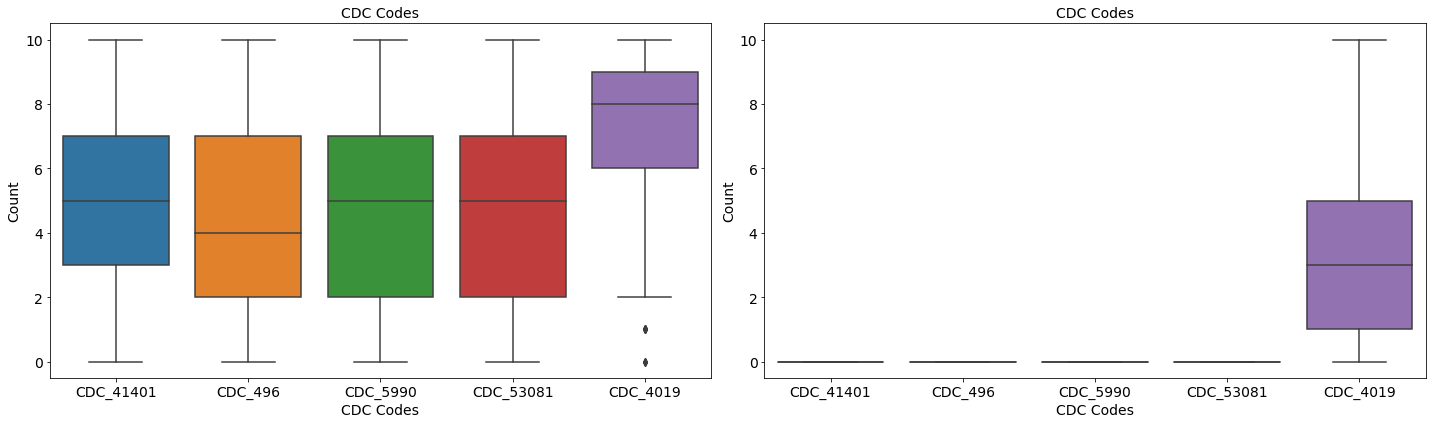

In [180]:
plt.figure(1)
plt.subplot(1, 2, 1)
df1 = Fraud_df[['CDC_41401', 'CDC_496', 'CDC_496', 'CDC_5990', 'CDC_53081', 'CDC_4019']]

sns.boxplot(x = "variable", y = "value", data = pd.melt(df1))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('CDC Codes', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('CDC Codes', fontsize = 14)

plt.subplot(1, 2, 2)
df2 = NFraud_df[['CDC_41401', 'CDC_496', 'CDC_5990', 'CDC_53081', 'CDC_4019']]
sns.boxplot(x = "variable", y = "value", data = pd.melt(df2))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('CDC Codes', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('CDC Codes', fontsize = 14)
plt.tight_layout()
plt.show()

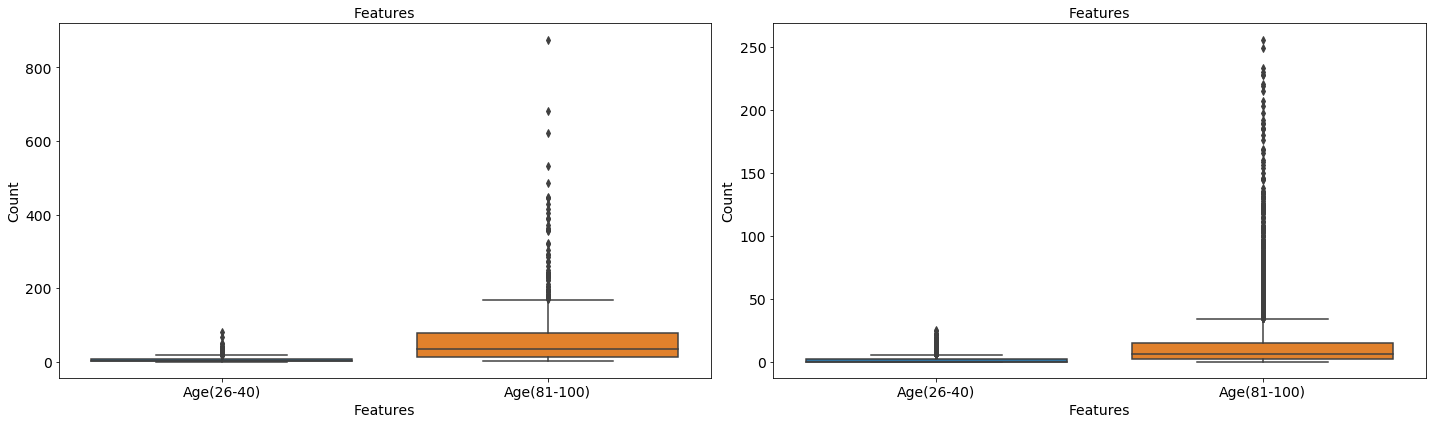

In [207]:
plt.figure(1)
plt.subplot(1, 2, 1)
df1 = Fraud_df[['Age(26-40)',  'Age(81-100)']]
sns.boxplot(x = "variable", y = "value", data = pd.melt(df1))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Features', fontsize = 14)


plt.subplot(1, 2, 2)
df2 = NFraud_df[['Age(26-40)',  'Age(81-100)']]
sns.boxplot(x = "variable", y = "value", data = pd.melt(df2))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Features', fontsize = 14)
plt.tight_layout()
plt.show()

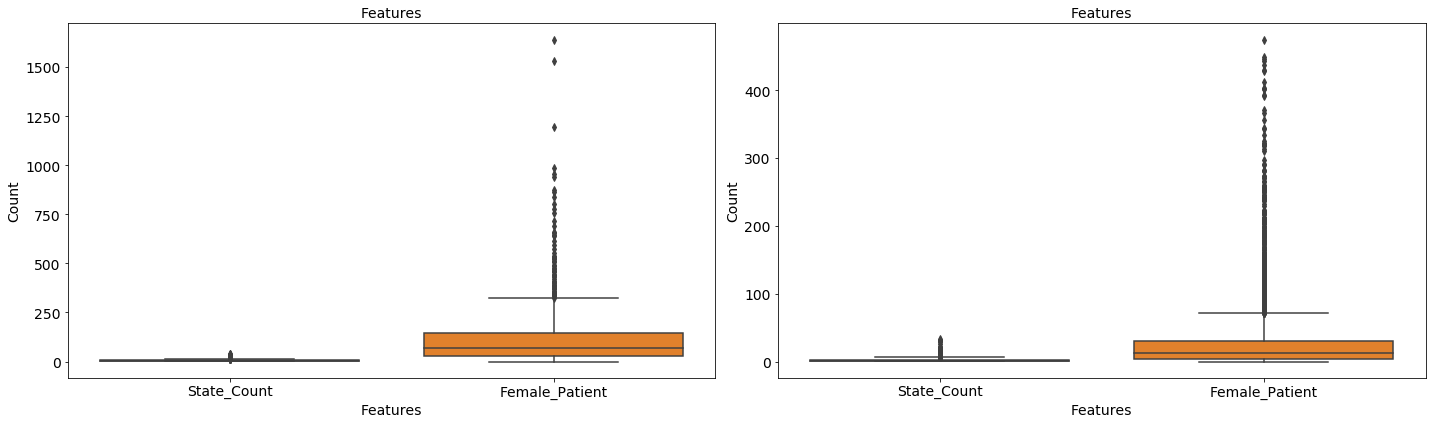

In [208]:
plt.figure(1)
plt.subplot(1, 2, 1)
df1 = Fraud_df[['State_Count',  'Female_Patient']]

sns.boxplot(x = "variable", y = "value", data = pd.melt(df1))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Features', fontsize = 14)

plt.subplot(1, 2, 2)
df2 = NFraud_df[['State_Count',  'Female_Patient']]
sns.boxplot(x = "variable", y = "value", data = pd.melt(df2))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Features', fontsize = 14)
plt.tight_layout()
plt.show()

In [76]:
Fraud_CM = Fraud_df.drop('Index', axis = 1).corr().unstack().drop_duplicates().\
to_frame().reset_index().rename(columns = {'level_0' : 'Feature1', 'level_1' : 'Feature2', 0 : 'Corr_Coef'})
Fraud_CM.loc[Fraud_CM.Corr_Coef < 0.91].sort_values(ascending = False, by = 'Corr_Coef').head(15)

,Feature1,Feature2,Corr_Coef
185,Age(41-60),Diabetes,0.909666
179,Age(41-60),Alzheimer,0.909217
430,Race_Hispanic,Race_Native,0.906634
188,Age(41-60),rheumatoidarthritis,0.906371
182,Age(41-60),Cancer,0.903338
1127,State_Count,County_Count,0.893143
189,Age(41-60),stroke,0.892325
127,Age(26-40),KidneyDisease,0.886312
129,Age(26-40),ObstrPulmonary,0.885502
132,Age(26-40),IschemicHeart,0.883842


In [77]:
NFraud_CM = NFraud_df.drop('Index', axis = 1).corr().unstack().drop_duplicates().\
to_frame().reset_index().rename(columns = {'level_0' : 'Feature1', 'level_1' : 'Feature2', 0 : 'Corr_Coef'})
NFraud_CM.loc[NFraud_CM.Corr_Coef < 0.91].sort_values(ascending = False, by = 'Corr_Coef').head(15)

,Feature1,Feature2,Corr_Coef
186,Age(41-60),IschemicHeart,0.909658
180,Age(41-60),Heartfailure,0.908376
181,Age(41-60),KidneyDisease,0.904854
184,Age(41-60),Depression,0.903741
187,Age(41-60),Osteoporasis,0.901695
183,Age(41-60),ObstrPulmonary,0.901632
295,Age(81-100),RenalDisease,0.901625
345,Race_White,stroke,0.900817
179,Age(41-60),Alzheimer,0.900430
188,Age(41-60),rheumatoidarthritis,0.899790
